# 01.1d: Generate Control Data (Random Gaussian Vectors)

**Goal:** Create a control dataset of random vectors to understand baseline high-dimensional geometry.

We'll generate vectors that match the token cloud's basic statistics but are **purely random**:
- Same dimensionality (2,560D)
- Same number of points (151,936)
- Centered at origin (mean = 0)
- Each coordinate drawn from Gaussian distribution
- Match the observed per-dimension variance (std ≈ 0.02)

This control dataset shows us what a **structureless high-dimensional Gaussian blob** looks like. Any deviations between the real tokens and this control indicate **real semantic structure** beyond random geometry.

## Mathematical Background

For each control vector **v** in ℝ²⁵⁶⁰:

$$v_i \sim N(0, \sigma^2) \text{ for } i = 1, 2, \ldots, 2560$$

where σ is chosen to match the observed token variance.

The resulting norms will follow a **Chi distribution** with 2,560 degrees of freedom.

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
RANDOM_SEED = 42

# Match the real token cloud parameters
NUM_VECTORS = 151_936  # Same as token count
NUM_DIMENSIONS = 2_560  # Same dimensionality
STD_PER_DIMENSION = 0.020688  # From 01.2b projection analysis

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import save_file
from pathlib import Path
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Generate Random Gaussian Vectors

In [3]:
print(f"Generating {NUM_VECTORS:,} random vectors in {NUM_DIMENSIONS:,}D space...")
print(f"Each coordinate: N(0, {STD_PER_DIMENSION**2:.6f})\n")

# Generate random Gaussian vectors
# Shape: (NUM_VECTORS, NUM_DIMENSIONS)
control_vectors = torch.randn(NUM_VECTORS, NUM_DIMENSIONS) * STD_PER_DIMENSION

print(f"Generated control vectors:")
print(f"  Shape: {control_vectors.shape}")
print(f"  Dtype: {control_vectors.dtype}")
print(f"  Memory: {control_vectors.element_size() * control_vectors.nelement() / 1024**2:.1f} MB")

Generating 151,936 random vectors in 2,560D space...
Each coordinate: N(0, 0.000428)

Generated control vectors:
  Shape: torch.Size([151936, 2560])
  Dtype: torch.float32
  Memory: 1483.8 MB


## Step 2: Verify Statistics

In [4]:
# Check that mean is at origin
mean = control_vectors.mean(dim=0)
mean_norm = mean.norm().item()

print(f"Mean verification:")
print(f"  Mean vector norm: {mean_norm:.2e}")
print(f"  Expected: ~0 (centered at origin)\n")

# Check per-dimension statistics
per_dim_mean = control_vectors.mean(dim=0)
per_dim_std = control_vectors.std(dim=0)

print(f"Per-dimension statistics:")
print(f"  Mean of means: {per_dim_mean.mean().item():.6e}")
print(f"  Mean of stds: {per_dim_std.mean().item():.6f}")
print(f"  Target std: {STD_PER_DIMENSION:.6f}")

Mean verification:
  Mean vector norm: 2.69e-03
  Expected: ~0 (centered at origin)

Per-dimension statistics:
  Mean of means: 5.190158e-07
  Mean of stds: 0.020687
  Target std: 0.020688


## Step 3: Compute Norms (Radial Distribution)

In [5]:
# Compute norms (distances from origin)
control_norms = control_vectors.norm(dim=1)

print(f"Control vector norms:")
print(f"  Mean: {control_norms.mean().item():.6f} gamma units")
print(f"  Std: {control_norms.std().item():.6f} gamma units")
print(f"  Min: {control_norms.min().item():.6f} gamma units")
print(f"  Max: {control_norms.max().item():.6f} gamma units")
print(f"  Median: {control_norms.median().item():.6f} gamma units")

# Compare to theoretical expectation for Chi distribution
theoretical_mean = np.sqrt(NUM_DIMENSIONS) * STD_PER_DIMENSION
print(f"\nTheoretical expectation (Chi distribution):")
print(f"  E[r] ≈ √{NUM_DIMENSIONS} × {STD_PER_DIMENSION:.6f} = {theoretical_mean:.6f}")
print(f"  Observed mean: {control_norms.mean().item():.6f}")
print(f"  Match: {'✓' if abs(control_norms.mean().item() - theoretical_mean) < 0.01 else '✗'}")

Control vector norms:
  Mean: 1.046609 gamma units
  Std: 0.014641 gamma units
  Min: 0.982935 gamma units
  Max: 1.116055 gamma units
  Median: 1.046585 gamma units

Theoretical expectation (Chi distribution):
  E[r] ≈ √2560 × 0.020688 = 1.046739
  Observed mean: 1.046609
  Match: ✓


## Step 4: Visualize Radial Distribution

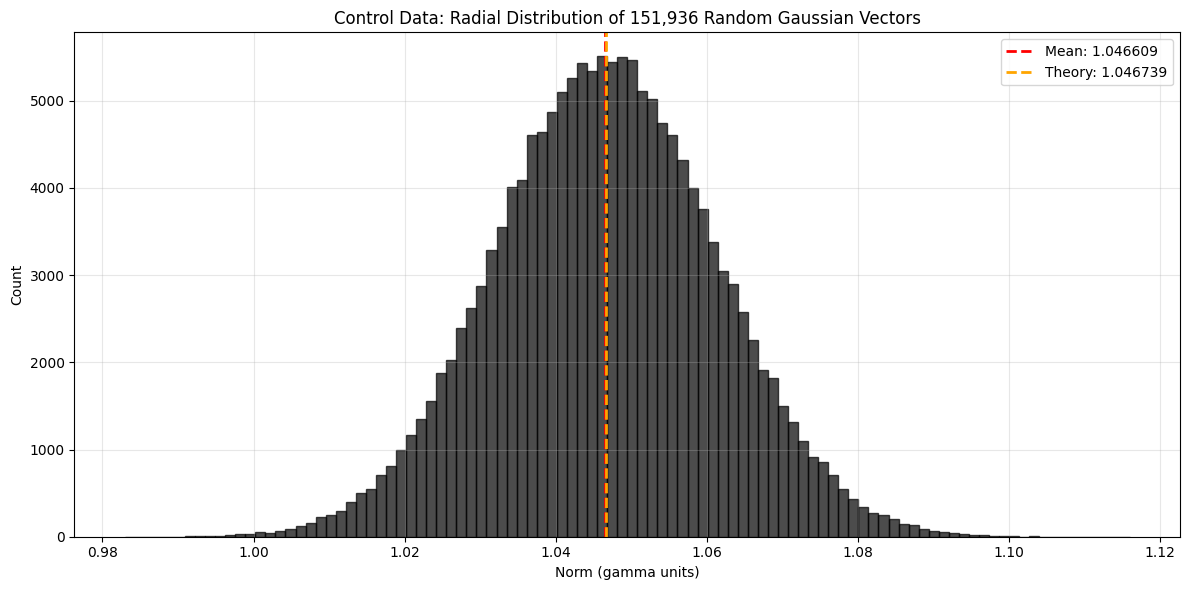


This is what pure high-dimensional Gaussian noise looks like!
Compare to real token distribution to identify semantic structure.


In [6]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

ax.hist(control_norms.cpu().numpy(), bins=100, color='black', alpha=0.7, edgecolor='black')
ax.axvline(control_norms.mean().item(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {control_norms.mean().item():.6f}')
ax.axvline(theoretical_mean, color='orange', linestyle='--', linewidth=2, 
           label=f'Theory: {theoretical_mean:.6f}')

ax.set_xlabel('Norm (gamma units)')
ax.set_ylabel('Count')
ax.set_title(f'Control Data: Radial Distribution of {NUM_VECTORS:,} Random Gaussian Vectors')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nThis is what pure high-dimensional Gaussian noise looks like!")
print("Compare to real token distribution to identify semantic structure.")

## Step 5: Test Projection Behavior

Projection onto random direction:
  Mean: 2.851920e-05
  Std: 0.020686
  Min: -0.088564
  Max: 0.089495


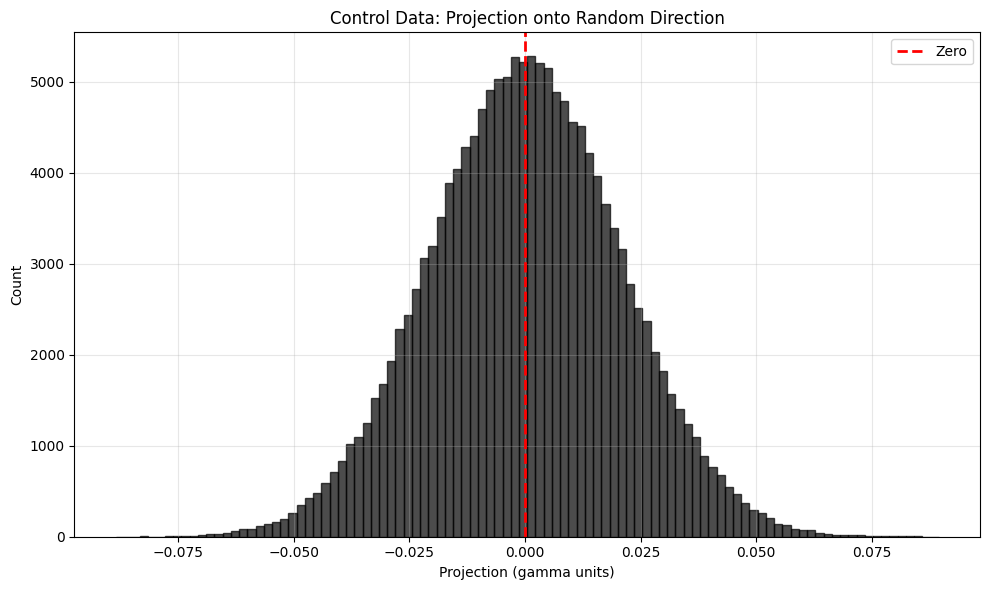


Projections are Gaussian and centered at zero, just like the real tokens!


In [7]:
# Pick a random direction and project
random_direction = torch.randn(NUM_DIMENSIONS)
random_direction = random_direction / random_direction.norm()

projections = control_vectors @ random_direction

print(f"Projection onto random direction:")
print(f"  Mean: {projections.mean().item():.6e}")
print(f"  Std: {projections.std().item():.6f}")
print(f"  Min: {projections.min().item():.6f}")
print(f"  Max: {projections.max().item():.6f}")

# Histogram
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.hist(projections.cpu().numpy(), bins=100, color='black', alpha=0.7, edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
ax.set_xlabel('Projection (gamma units)')
ax.set_ylabel('Count')
ax.set_title('Control Data: Projection onto Random Direction')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nProjections are Gaussian and centered at zero, just like the real tokens!")

## Step 6: Save Control Data

In [8]:
# Save control vectors
control_path = Path(TENSOR_DIR) / "control_vectors_gaussian.safetensors"
save_file({'control_vectors': control_vectors.contiguous()}, control_path)
print(f"Saved control vectors to: {control_path}")

# Save control norms (for easy comparison)
control_norms_path = Path(TENSOR_DIR) / "control_norms_gaussian.safetensors"
save_file({'control_norms': control_norms.contiguous()}, control_norms_path)
print(f"Saved control norms to: {control_norms_path}")

Saved control vectors to: ../data/tensors/control_vectors_gaussian.safetensors
Saved control norms to: ../data/tensors/control_norms_gaussian.safetensors


## Summary

Successfully generated control dataset of **purely random Gaussian vectors**.

Key properties:
- **151,936 vectors** in **2,560D** space
- **Centered at origin** (mean ≈ 0)
- **Per-dimension std ≈ 0.0207** (matching real tokens)
- **Radial distribution** follows Chi distribution with mean ≈ 1.05 gamma units
- **No structure** - pure statistical noise

This baseline shows what high-dimensional geometry alone produces. Any differences between real tokens and this control indicate **semantic structure** in the token embeddings.

Next steps:
- Compare real token norms vs control norms (look for deviations)
- Compare pairwise distances
- Compare angular distributions
- Identify where tokens differ from random noise!